<a href="https://colab.research.google.com/github/SantiagoZeitunian/Manuela-_Cardona_Santiago_Zeitunian_PI_AMD_2023/blob/main/Manuela__Cardona_Santiago_Zeitunian_PI_AMD_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center><b> PROYECTO INTEGRADOR AMD</b></center>
## <center><b>Universidad Tecnológica de Uruguay - UTEC - ITR CS</b></center>
## <center>Nelcy Natalia Atehortua</center>
## <center>Juan Blandón</center>

**Equipo: Manuela Cardona, Santiago Zeitunian**

**Tutor: Juan S. Blandón**

## <center><b>Librerías y Paquetes</b></center>

In [ ]:
# Se instala ggplot (La primera que anda)
!pip install -U ggplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.7 MB/s eta 0:00:00


In [ ]:
# Otra manera de ggplot
#!pip install ggplot

In [ ]:
# Se instala plotnine
!pip install plotnine

In [ ]:
# Se importan funciones auxiliares desde GitHub requeridas para el desarrollo de
# este práctico
#!git clone https://github.com/jsblandon/weather_data_uy_preprocessing.git
import sys
#sys.path.append('/content/weather_data_uy_preprocessing')

In [ ]:
# Se importan las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files, drive
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.preprocessing import StandardScaler

#from weather_data_preprocessing import null_report
# Se agregan estas librerías
import math
import scipy.stats as sp
from scipy.stats import skew

import statsmodels.api as sm

#Para hacer gráfico de autocorrelación
import statsmodels.api as sm

## permite la conexión de carpetas específicas de nuestro Google Drive
from google.colab import files, drive
from statsmodels.tsa.seasonal import seasonal_decompose

#Para trabajar con plotnine de ggplot
from plotnine import *
from plotnine import ggplot, aes, geom_line, geom_point, labs, theme_minimal, theme, element_text, ggtitle
# Librerias extraídas del notebook del modelo de predicción.
from math import sqrt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_error

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

sns.set_style('whitegrid')

# Se importan las librerías necesarias
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

sns.set_style('whitegrid')
warnings.filterwarnings("ignore")

In [ ]:
#plt.rc('font', size=16)
#plt.rc('axes', labelsize=18, titlesize=14)
#plt.rc('legend', fontsize=14)
#plt.rc('xtick', labelsize=14)
#plt.rc('ytick', labelsize=14)

## <center><b>Funciones</b></center>

In [ ]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    f""" Funcion para guardar figuras eficientemente

        Recibe
        ------
        fig_id : string
            Identificador de la figura

        Devuelve
        --------
        Figura almacenada en el directorio de trabajo

        Fuente: Géron, A. (2022). Hands-on machine learning with Scikit-Learn,
        Keras, and TensorFlow. " O'Reilly Media, Inc.".

    """
    path =  f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution,bbox_inches="tight",transparent=True)

In [ ]:
def serie_temp_ml_supervisado(data, n_in=1, n_out=1, dropnan=True):
	f""" Funcion que convierte una serie temporal a un conjunto de datos del tipo ML supervisado

	Recibe
    ------
    data: DataFrame
        Secuencia de observaciones como lista, arreglo de NumPy o DataFrame
    n_in: int
        Numero de observaciones retrasadas como entrada (X)
    n_out: int
        Numero de observaciones como salida (y).
    dropnan: bool
        Bandera que decide si se preservan o no los NaN generados en el proceso

	Devuelve
    --------
    df_lag : DataFrame
        Serie temporal con ventaneo para tarea de ML supervisado

    Fuente: Brownlee, J. (2017). How to Convert a Time Series to a Supervised
            Learning Problem in Python.

	"""

	n_vars = 1 if type(data) is list else data.shape[1]

	df = pd.DataFrame(data)
	cols, names = list(), list()

	# Secuencia de entrada (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

	# Secuencia de predicción (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

	# Se concatena todo
	df_lag = pd.concat(cols, axis=1)
	df_lag.columns = names

	# Se descartan los NaN resultantes
	if dropnan:
		df_lag.dropna(inplace=True)

	return df_lag

In [ ]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

## <center><b>Preprocesamiento de Datos</b></center>

Para este práctico se usarán datos relacionados al curso de Proyecto Integrador para tratar algunas de las tareas previas que se deben desarrollar en el momento que se quiera acondicionar datos:

In [ ]:
# Carga de los datos: carguen aquí todos los datos a los que ya tienen acceso
from google.colab import files
uploaded = files.upload()

Saving 2018_2022_egei_ancap.csv to 2018_2022_egei_ancap.csv


* **Datos de Gases de Efecto Invernadero**

In [ ]:
# Carga de los datos
ruta_gei = '/content/2018_2022_egei_ancap.csv'
data_gei = pd.read_csv(ruta_gei,
                       # Tipo de delimitador
                       delimiter = ';',
                       # Indicador decimal
                       decimal=",")

In [ ]:
# Se agrega una columna adicional de día para luego poderla convertir en un
# índice
data_gei['Dia'] = 1

# Se convierten las columnas de fecha de inglés a español
data_gei = data_gei.rename(columns={"Año": "year", "Mes": "month", "Dia":"day"})

# Se genera la columna de fecha
data_gei['date'] = pd.to_datetime(data_gei.year*10000+data_gei.month*100+data_gei.day,format='%Y%m%d')

# Se descartan las columnas de year, month y day y se fija date como índice
data_gei = data_gei.drop(columns = ['year','month','day'])
data_gei.set_index('date',inplace=True)

In [ ]:
data_gei

,Valor,Unidad
date,,
2018-01-01,64716.20,TonCO2Eq
2018-02-01,52402.79,TonCO2Eq
2018-03-01,44073.98,TonCO2Eq
2018-04-01,39412.51,TonCO2Eq
2018-05-01,70101.08,TonCO2Eq
2018-06-01,53468.17,TonCO2Eq
2018-07-01,64065.19,TonCO2Eq
2018-08-01,70765.36,TonCO2Eq
2018-09-01,63556.24,TonCO2Eq


### **Análisis Exploratorio de Datos**

#### **Medidas de Tendencia**

Lo primero que queremos determinar es tendencias en los datos. Esto podemos hacerlo mediante **medidas de posición**. Recordemos que hay de dos tipos: de tendencia central y no central. A partir de lo anterior se pueden empezar deducir comportamientos relacionados a nuestras problemáticas:

In [ ]:
# PASO 1: Identifique las medidas de posición, sea de tendencia central o no
# central que pueda calcular sobre sus datos. NOTA: puede consultar estrategias
# para hacerlo con las funcionalidades que ofrece la librería Pandas de Python

#TENDENCIA CENTRAL
media = data_gei['Valor'].mean()
print("La media es: ", media)

mediana = data_gei['Valor'].median()
print("\nLa mediana es: ", mediana)

#TENDENCIA NO CENTRAL
Q1 = data_gei.quantile(0.25, numeric_only=True)
Q2 = data_gei.quantile(0.5, numeric_only=True)
Q3 = data_gei.quantile(0.75, numeric_only=True)

print("\nPrimer Cuartil (Q1):", Q1)
print("\nSegundo Cuartil (Q2):", Q2)
print("\nTercer Cuartil (Q3):", Q3)

La media es:  55047.8038

La mediana es:  53445.84

Primer Cuartil (Q1): Valor    47936.0025
Name: 0.25, dtype: float64

Segundo Cuartil (Q2): Valor    53445.84
Name: 0.5, dtype: float64

Tercer Cuartil (Q3): Valor    60971.6525
Name: 0.75, dtype: float64


In [ ]:
# PASO 2: Justifique por qué eligió las medidas que eligió
# Se eligieron estas medidas de posición ya que, estas son muy importantes para conocer más al detalle nuestro conjunto de datos,
# Se decidió no calcular la moda, ya que se conoce que nuestro conjunto de datos no cuenta con una.

In [ ]:
# PASO 3: Discuta los resultados que obtuvo sobre sus datos
# Se tiene que la media es mayor que la mediana, esto da indicios de que la asimetría de los datos es positiva, una asimetría que
# se caracteriza por tener la cola de la derecha más alargada que la de la izquierda.

#### **Medidas de Dispersión**

Una vez hemos identificado tendencias, a veces pueden verse comportamientos inesparados, quizás asociados a medidas atípicas que quizás puedan ser reflejadas a través de medidas de dispersión. Recordemos que hay de dos tipos: absolutas y relativas:

In [ ]:
# PASO 4: Identifique las medidas de dispersión, sean absolutas o relativas
# que pueda calcular sobre sus datos. NOTA: puede consultar estrategias
# para hacerlo con las funcionalidades que ofrece la librería Pandas de Python

# MEDIDAS DE DISPERSIÓN ABSOLUTAS

# RANGO MUESTRAL (R)
valor_maximo = data_gei['Valor'].max()                   # Se calcula el valor máximo de data_gei.
valor_minimo = data_gei['Valor'].min()                   # Se calcula el valor mínimo de data_gei.
print('El valor mínimo es: ', valor_minimo)              # Se imprime el valor míninmo
print('El valor máximo es: ', valor_maximo)              # Se imprime el valor máximo.

print('\nMEDIDAS DE DISPERSIÓN ABSOLUTAS')
rango_muestral_data_gei = valor_maximo - valor_minimo    # Se calcula el rango muestral.
print("\nEl Rango Muestral es: ", rango_muestral_data_gei) # Se imprime el rango muestral.

# VARIANZA MUESTRAL (s^2)
valor_data_gei = data_gei['Valor']                                                    # Se separa la columna "Valor" del dataframe para utilizarla en la fórmula.
Varianza_Muestral = ((valor_data_gei - media) ** 2).sum() / (len(valor_data_gei) - 1) # Se calcula la varianza muestral.
print("\nLa Varianza Muestral es:", Varianza_Muestral)                                      # Se imprime el resultado de la varianza muestral.

# DESVIACIÓN TÍPICA MUESTRAL (s)
Desviacion_Tipica_Muestral = math.sqrt(Varianza_Muestral)                 # Se calcula ra raíz cuadrada utilizando la libreria math .
print('\nLa Desviación Típica Muestral es: ', Desviacion_Tipica_Muestral) # Se imprime el resultado de la Desviación Típica Muestral.

# MEDIDA DE DISPERSIÓN RELATIVA
print('\nMEDIDA DE DISPERSIÓN RELATIVA')
# COEFICIENTE DE VARIACIÓN (CV)
Coeficiente_Variacion = Desviacion_Tipica_Muestral / media         # Se divide la Desviación Típica Muestral sobre la media para calcular el coeficient de variación.
print('\nEl Coeficiente de Variación es: ', Coeficiente_Variacion) # Se imprime en pantalla el coeficiente de variación.

El valor mínimo es:  32567.0
El valor máximo es:  83829.58

MEDIDAS DE DISPERSIÓN ABSOLUTAS

El Rango Muestral es:  51262.58

La Varianza Muestral es: 132234985.38330567

La Desviación Típica Muestral es:  11499.347172048754

MEDIDA DE DISPERSIÓN RELATIVA

El Coeficiente de Variación es:  0.20889747416315188


In [ ]:
# PASo 5: Justifique por qué eligió las medidas que eligió
# La desviación típica muestral (s) se eligió ya que es el segundo momento estadístico, y este es un dato muy importante, permite saber cuanto
# se separan los datos respecto a la media. Indicando la variabilidad del conjunto de datos.
# El Rango Muestral (R) nos ayudó a identificar el valor mínimo y máximo de nuestro conjunto de datos, y al restar ambos, nos dio 51262.58,
# este valor es la amplitud de nuestros datos. Esta media en conjunto con el CV, nos permite identificar si la media es representativa.
# Concluimos que el coeficiente de variación es pequeño (0.20889747416315188), por lo que la media es representativa.

In [ ]:
# PASO 6: Discuta los resultados que obtuvo sobre sus datos
# Se concluyó que la media es una medida representativa de los datos.
# El valor mínimo fue registrado en setiembre de 2021, mientras que el máximo valor en mayo de 2019.

#### **Medidas de Forma**

Tras calcular medidas de tendencia y dispersión, se debe proceder a calcular medidas de forma; esto va a complementar el entendimiento de los datos sobre la problemática, con el fin de responder una simple pregunta: ¿son las variables medidas sobre los datos de interés normales o no?

In [ ]:
# PASO 7: Identifique las medidas de forma que considere pertinentes calcular
# sobre sus datos, esto con el fin de intuir si hay normalidad o no. NOTA: puede
# consultar estrategias para hacerlo con las funcionalidades que ofrece la
# librería Pandas de Python

print('MEDIDAS DE FORMA\n')
# TERCER MOMENTO ESTADÍSTICO - COEFICIENTE DE FISHER
coeficiente_Fisher  = skew(data_gei['Valor'])

print("El coeficiente de Fisher es:", coeficiente_Fisher)

# COEFICIENTE DE PEARSON
coeficiente_Pearson = data_gei['Valor'].corr(data_gei['Valor'])
print("\nEl coeficiente de Pearson es: ", coeficiente_Pearson)

# CUARTO MOMENTO ESTADÍSTICO - COEFICIENTE DE CURTOSIS
curtosis = sp.kurtosis(valor_data_gei)
print("\nEl coeficiente de Curtosis es: ", curtosis)


MEDIDAS DE FORMA

El coeficiente de Fisher es: 0.4467800295965085

El coeficiente de Pearson es:  1.0

El coeficiente de Curtosis es:  0.0906031025763232


In [ ]:
# PASO 8: Justifique por qué eligió las medidas que eligió
# En primer lugar se calculó el coeficiente de Fisher, el tercer momento estadístico, porque este nos indica el tipo de simetría del conjunto de datos.
# Realizamos Pearson para verificar si la media se desplazaba a la derecha de la mediana.
# Por último, se realizó el coeficiente de Curtosis (cuarto momento estadístico), y este nos ayuda a conocer el apuntalamiento que presentan los datos.

In [ ]:
# PASO 9: Discuta los resultados que obtuvo sobre sus datos
# El coeficiente de simetría de Fisher nos dio un valor de 0.4467800295965085, lo cual al ser mayor a 0, determina que se trata de
# una asimetría positiva. Veríamos que la "cola" de la derecha es más larga que la de la izquierda, si realizáramos el gráfico.
# El coeficiente de Pearson al ser > 0 también nos indicó y confirmó, que la distribución es asimétrica positiva.
# Finalmente la curtosis nos señaló que el apuntalamiento de los datos es leptocúrtico. Si graficáramos, podríamos ver una concentración de valores
# más pronunciada en el centro del gráfico, en comparación con una distribución normal de los datos.

#### **Representaciones Gráficas**

Habiendo calculado medidas estadísticas sobre nuestros datos para describirlos, podemos complementar el análisis mediante gráficas:

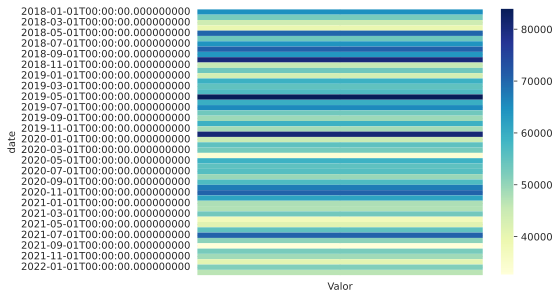

In [ ]:
# PASO 10: Verifique gráficamente que la presencia/ausencia de datos faltantes.
# Consulte el uso de la función de seaborn heatmap() y grafique las variables
# de su conjunto de datos:

sns.heatmap(data_gei[['Valor']], cmap="YlGnBu", cbar=True) # Tenemos una sola variable, y creemos que no se puede correlacionar con otra.
plt.show()

<center> Figura 1. Mapa de calor de los datos de GEI, ANCAP.

Observación: en este caso al solo tener una variable cuantificable (valores de medidas de CO2eq), no hay otra con la cual correlacionarla, ya que la unidad que representaría otra variable, es en realidad constante. Es por esto, que el mapa de calor presentado no brinda información relevante.

In [ ]:
# PASO 11: ¿Hay datos faltantes o no? ¿Es evidente que hay muchos o no?
# No, no existen datos faltantes en el DataFrame "data_gei", sin embargo esto no es evidente en el mapa de calor
# generado en el paso anterior.

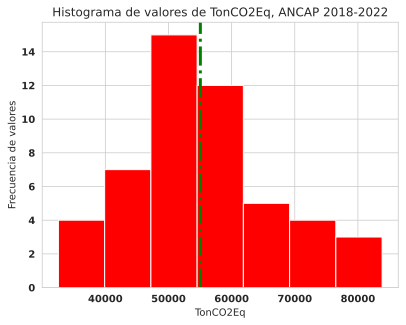

In [ ]:
# PASO 12: Identifique a partir de las gráficas vistas en el curso de AMD
# una o varias de las representaciones visuales que le permitan ver
# tendencias, relaciones, forma, datos atípicos y otros que considere
# pertinentes

plt.hist(data_gei['Valor'], bins=7, color='r')  # Se ajusta el número de bins
plt.axvline(media, color='green', linestyle='-.', linewidth=3) # Se agrega una línea vertical indicando la media.
plt.xlabel('TonCO2Eq')
plt.ylabel('Frecuencia de valores')
plt.title('Histograma de valores de TonCO2Eq, ANCAP 2018-2022') # Se elige un título representativo.
plt.xticks(weight = 'bold')
plt.yticks(weight = 'bold')
#save_fig("Histograma de valores de TonCO2Eq, ANCAP 2018-2022", tight_layout=True, fig_extension="svg", resolution=300)
plt.show()

<center> Figura 2. Histograma de valores de TonCO2Eq, ANCAP 2018-2022.

Fuente de los datos: ANCAP.

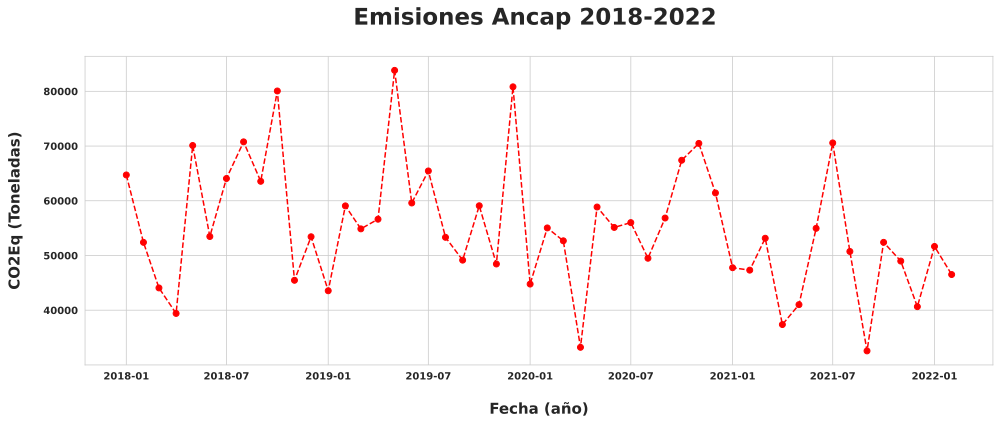

In [ ]:
# Gráfica de líneas y puntos
plt.figure(figsize=(14,6)) # Se cambia el tamaño de la figura en cuestión
plt.plot(data_gei['Valor'], 'r', marker='o', linestyle='--') # Se crea la gráfica a partir del conjunto de datos  y su columna 'Valor'.
plt.xlabel('\nFecha (año)', fontsize = 15, fontweight='bold') # Nombre del eje x.
plt.ylabel('CO2Eq (Toneladas)\n', fontsize = 15, fontweight='bold') # Nombre del eje y.
plt.title('Emisiones Ancap 2018-2022 \n',fontsize=23, fontweight='bold') # Se agrega el título con tamaño de letra 15 y negrita 'bold'.
plt.xticks(weight = 'bold')
plt.yticks(weight = 'bold')
plt.tight_layout()
#save_fig("Serie_temporal_Emisiones_corregida", tight_layout=True, fig_extension="svg", resolution=300)
plt.show() # Se muestra la gráfica.

<center> Figura 3.  Gráfica de líneas y puntos para las emisiones de ANCAP 2018-2022.

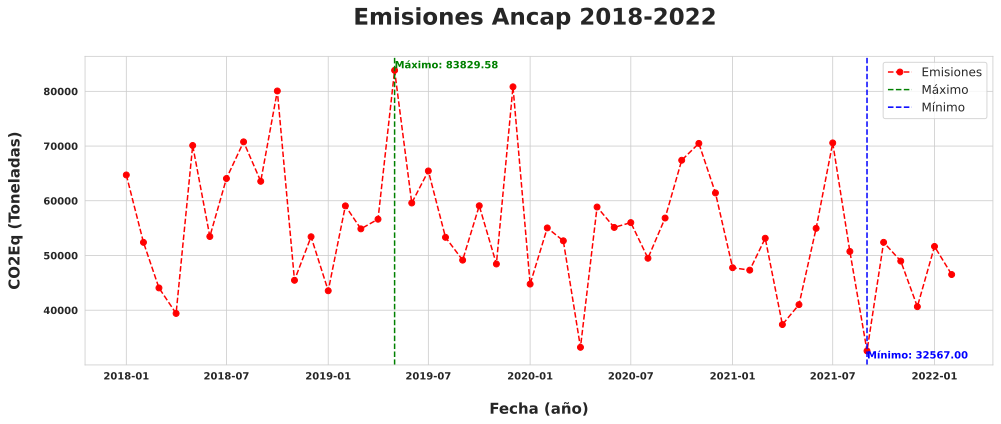

In [ ]:
# Se calcula el índice del valor máximo y mínimo en los datos.
indice_max = data_gei['Valor'].idxmax()
indice_min = data_gei['Valor'].idxmin()
valor_max = data_gei['Valor'].max()
valor_min = data_gei['Valor'].min()

# Se gráfica de líneas y puntos.
plt.figure(figsize=(14, 6))
plt.plot(data_gei['Valor'], 'r', marker='o', linestyle='--', label='Emisiones')
plt.xlabel('\nFecha (año)', fontsize=15, fontweight='bold')
plt.ylabel('CO2Eq (Toneladas)\n', fontsize=15, fontweight='bold')
plt.title('Emisiones Ancap 2018-2022 \n', fontsize=23, fontweight='bold')
plt.xticks(weight='bold')
plt.yticks(weight='bold')

# Se agrega líneas verticales en el máximo y mínimo.
plt.axvline(x=indice_max, color='g', linestyle='--', label='Máximo')
plt.axvline(x=indice_min, color='b', linestyle='--', label='Mínimo')

# Se arega texto con los valores del máximo y mínimo.
plt.text(indice_max, valor_max, f'Máximo: {valor_max:.2f}', color='g', fontsize=10, ha='left', va='bottom', fontweight='bold')
plt.text(indice_min, valor_min, f'Mínimo: {valor_min:.2f}', color='b', fontsize=10, ha='left', va='top', fontweight='bold')

plt.legend(fontsize='12')

plt.tight_layout()
save_fig("Serie_temporal_Emisiones_corregida_minmax", tight_layout=True, fig_extension="svg", resolution=300)
plt.show()

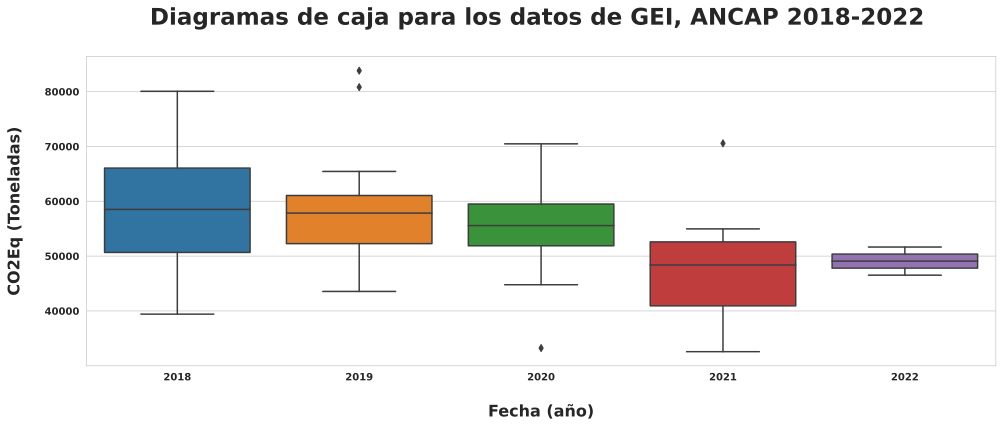

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))
sns.boxplot(x = data_gei.index.year,# Se grafican los box-plot por año.
                y = data_gei['Valor'], # Elegimos la columna "valor".
                ax = ax)
ax.set_title('Diagramas de caja para los datos de GEI, ANCAP 2018-2022 \n', fontsize = 23, fontweight='bold')
ax.set_ylabel("CO2Eq (Toneladas)\n", fontsize=16, fontweight="bold")
ax.set_xlabel("\nFecha (año)", fontsize=16, fontweight="bold")
plt.xticks(weight = 'bold')
plt.yticks(weight = 'bold')
plt.tight_layout()
#save_fig("Diagramas_de_caja_corregida", tight_layout=True, fig_extension="svg", resolution=300)

<center> Figura 4. Diagramas de caja o box-plots para los datos de GEI, ANCAP 2018-2022

### <center><b>Medias Móvil, Descomposición de la serie, otra info gráficos </b></center>

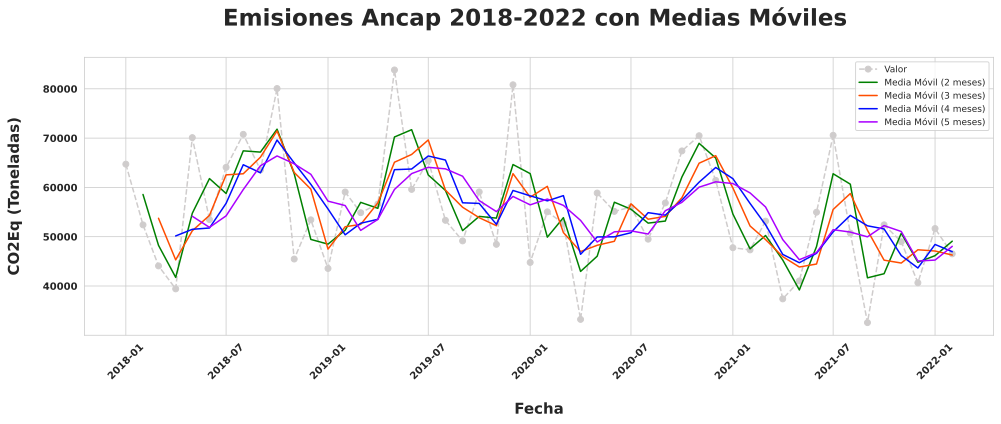

In [ ]:
# VENTANA 2
data_gei['MediaMovil2'] = data_gei['Valor'].rolling(window=2).mean()

# VENTANA 3
data_gei['MediaMovil3'] = data_gei['Valor'].rolling(window=3).mean()
# VENTANA 4
data_gei['MediaMovil4'] = data_gei['Valor'].rolling(window=4).mean()

# VENTANA 5
data_gei['MediaMovil5'] = data_gei['Valor'].rolling(window=5).mean()

# Se crea la gráfica
plt.figure(figsize=(14,6))
plt.plot(data_gei['Valor'], 'o--', label='Valor', color='#CFCCCC')

# Se crea la gráfica de la media móvil 2
plt.plot(data_gei['MediaMovil2'], label='Media Móvil (2 meses)', color='green')

# Se crea la gráfica de la media móvil 3
plt.plot(data_gei['MediaMovil3'], label='Media Móvil (3 meses)', color='#FF4D00')

# Se crea la gráfica de la media móvil 4
plt.plot(data_gei['MediaMovil4'], label='Media Móvil (4 meses)', color='#000CFF')

# Se crea la gráfica de la media móvil 5
plt.plot(data_gei['MediaMovil5'], label='Media Móvil (5 meses)', color='#AA00FF')

# Se nombran los ejes y se elije título
plt.xlabel('\nFecha', fontsize = 15, fontweight='bold')
plt.ylabel('CO2Eq (Toneladas)\n', fontsize = 15, fontweight='bold')
plt.title('Emisiones Ancap 2018-2022 con Medias Móviles \n', fontsize = 23, fontweight='bold') # Se agrega el título con tamaño de letra 15 y negrita 'bold'.
plt.xticks(rotation=45)
plt.xticks(weight = 'bold')
plt.yticks(weight = 'bold')
plt.tight_layout()
# Mostrar una leyenda
plt.legend(fontsize='9')
save_fig("Emisiones_con_Medias_Móviles_corregida2", tight_layout=True, fig_extension="svg", resolution=300)

<center>Figura 5. Emisiones Ancap 2018-2022 con media móvil, resaltado de tendencias intrínsecas.

In [ ]:
# PASO 13: Justique los tipos de gráficos usados y por qué le vienen bien  a
# a su análisis para su problemática
# La primer representación visual realizada fue el histograma, porque nos permitió ver en qué rango de valores de TonCO2Eq se encontraba la
# mayor cantidad de datos, y a su vez, nos confirmó que se trata de un tipo de asimetría positiva. La cola de la derecha es visiblemente más
# grande que la de la izquierda. Esto confirmó que nuestros cálculos son correctos.
# Luego se realizó una gráfica de puntos y líneas punteadas (figura 3) para rastrear más fácilmente tendencias, y poder así realizar un
# diagnóstico preliminar de la variable. Aquí se buscaron posibles patrones.
# Como se ve en la fig. 4, hicimos un gráfico de box-plot o digramas de caja, para identificar datos atípicos.
# Al final se gráfican los datos con la media móvil (figura 5), porque esta es útil para suavizar las fluctuaciones en una serie de datos,
# y resaltar tendencias a largo plazo. También para observar la tendencia intrínseca de los datos, es decir de nuestra serie temporal.

In [ ]:
# Descomposición de la serie
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(8,5)
    plt.show()

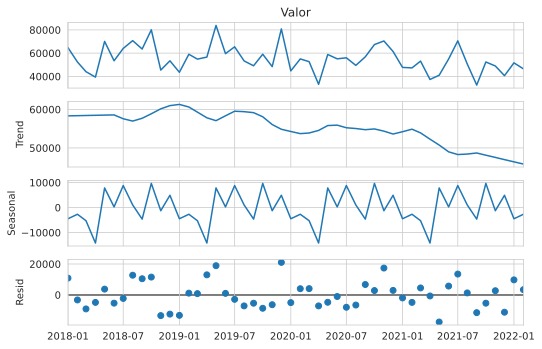

In [ ]:
seasonal_decompose(data_gei['Valor'])
# save_fig("Descomposición de la serie temporal", tight_layout=True, fig_extension="png", resolution=300)

In [ ]:
data_gei_final = data_gei.drop(# Agrgue el nombre de las columnas a descartar como lista
                                                       labels = ['Unidad'],
                                                       # Agregue a través de qué eje quiere descartar (0 - filas, 1 - columnas)
                                                       axis = 1)
data_gei_final.head(5)

,Valor,MediaMovil2,MediaMovil3,MediaMovil4,MediaMovil5
date,,,,,
2018-01-01,64716.20,NaN,NaN,NaN,NaN
2018-02-01,52402.79,58559.495,NaN,NaN,NaN
2018-03-01,44073.98,48238.385,53730.990000,NaN,NaN
2018-04-01,39412.51,41743.245,45296.426667,50151.37,NaN
2018-05-01,70101.08,54756.795,51195.856667,51497.59,54141.312


## <center><b>Aprendizaje a Partir de Datos</b></center>

### **Regresión Lineal Simple**

In [ ]:
data_gei_final

,Valor,MediaMovil2,MediaMovil3,MediaMovil4,MediaMovil5
date,,,,,
2018-01-01,64716.20,NaN,NaN,NaN,NaN
2018-02-01,52402.79,58559.495,NaN,NaN,NaN
2018-03-01,44073.98,48238.385,53730.990000,NaN,NaN
2018-04-01,39412.51,41743.245,45296.426667,50151.3700,NaN
2018-05-01,70101.08,54756.795,51195.856667,51497.5900,54141.312
2018-06-01,53468.17,61784.625,54327.253333,51763.9350,51891.706
2018-07-01,64065.19,58766.680,62544.813333,56761.7375,54224.186
2018-08-01,70765.36,67415.275,62766.240000,64599.9500,59562.462
2018-09-01,63556.24,67160.800,66128.930000,62963.7400,64391.208


In [ ]:
data_gei_final.dropna(inplace = True)

In [ ]:
data_gei_final_completa = data_gei_final['MediaMovil3'].to_frame()

In [ ]:
# Se declara el modelo
SLR = LinearRegression()

In [ ]:
# Se estandarizan de datos
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

In [ ]:
data_gei_final_completa = pd.DataFrame(sc.fit_transform(data_gei_final_completa), columns = data_gei_final_completa.columns, index=data_gei_final_completa.index)

In [ ]:
# Se genera una versión apta de la serie temporal para generar predicciones de tipo Forecasting
df_ts_lag = serie_temp_ml_supervisado(data_gei_final_completa,n_in = 1)
df_ts_lag.head()

,var1(t-1),var1(t)
date,,
2018-06-01,-0.561450,-0.134699
2018-07-01,-0.134699,0.985202
2018-08-01,0.985202,1.015378
2018-09-01,1.015378,1.473650
2018-10-01,1.473650,2.200295


In [ ]:
# Se subdividen los datos en Train y Test
porcentaje = 0.2
n_train = int(len(df_ts_lag) - len(df_ts_lag)*porcentaje)
X_train, X_test = df_ts_lag.iloc[0:n_train,0:-1], df_ts_lag.iloc[n_train:-1,0:-1]
y_train, y_test = df_ts_lag.iloc[0:n_train,-1], df_ts_lag.iloc[n_train:-1,-1]

In [ ]:
# Se declara el modelo
SLR = LinearRegression(n_jobs = -1)

# Training (Entrenamiento)
SLR.fit(X_train,y_train)

# Testing (Prueba - Predicciones)
y_pred = SLR.predict(X_test)

# Evaluación de desempeño sobre Test
error_skl = sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: %.15f' % (error_skl))

RMSE: 0.686616777593140


In [ ]:
# PRUEBA Regresión Lineal Simple


# Supongamos que y_test y y_pred son tus conjuntos de datos de prueba y predicciones, respectivamente.

# Cálculo de RMSE, MAE y MSE
rmse_lineal = sqrt(mean_squared_error(y_test, y_pred))
mae_lineal = mean_absolute_error(y_test, y_pred)
mse_lineal = mean_squared_error(y_test, y_pred)

# Imprimir resultados
print(f'RMSE: {rmse_lineal} , MAE: {mae_lineal}, MSE: {mse_lineal}')


RMSE: 0.6866167775931404 , MAE: 0.604538231023666, MSE: 0.4714425992723881


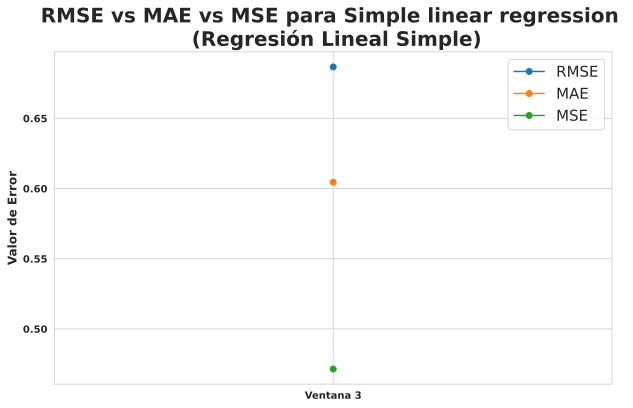

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(rmse_lineal, 'o-')  # Grafica del RMSE.
plt.plot(mae_lineal, 'o-')   # Grafica del MAE.
plt.plot(mse_lineal, 'o-')   # Grafica del MSE.

# Se cambia los valores del eje x
plt.xticks([0], ["Ventana 3"])

plt.title('RMSE vs MAE vs MSE para Simple linear regression \n (Regresión Lineal Simple)', fontsize=20, fontweight='bold')
plt.xlabel('', fontsize=12, fontweight='bold')  # Se agrega etiqueta al eje x.
plt.ylabel('Valor de Error', fontsize=12, fontweight='bold')
plt.legend(['RMSE', 'MAE', 'MSE'], fontsize='15')  # Se agrega la leyenda, y se modifica su tamaño.
plt.xticks(weight='bold')
plt.yticks(weight='bold')
plt.show()

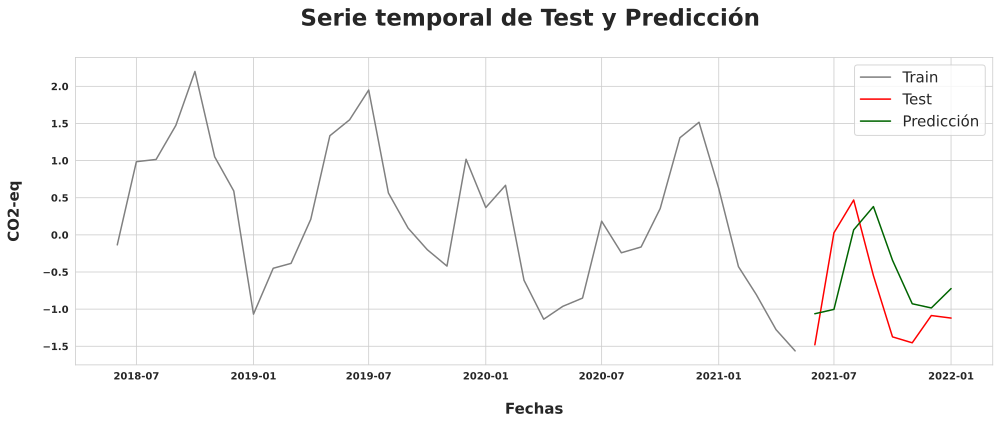

In [ ]:
# Se grafica la serie temporal de Test (Prueba) y la Predicción
plt.figure(figsize=(14,6))
plt.plot(y_train, color='grey')
plt.plot(y_test,  color='red')
plt.plot(y_test.index,y_pred,  color='darkgreen')
plt.legend(loc='upper right', labels=['Train','Test', 'Predicción'], fontsize='15')
plt.xlabel("\nFechas", fontsize = 15, fontweight='bold')
plt.ylabel("CO2-eq\n", fontsize = 15, fontweight='bold')
plt.title('Serie temporal de Test y Predicción \n', fontsize = 23, fontweight='bold') # Se agrega el título con tamaño de letra 15 y negrita 'bold'.
plt.xticks(weight = 'bold')
plt.yticks(weight = 'bold')
plt.tight_layout()
#save_fig("Serie_temporal_de_Test_y_Predicción_corregida", tight_layout=True, fig_extension="svg", resolution=300)
plt.show()

# **Ridge Regression**

In [ ]:
# Se subdividen los datos en Train y Test
porcentaje = 0.2
n_train = int(len(df_ts_lag) - len(df_ts_lag)*porcentaje)
X_train, X_test = df_ts_lag.iloc[0:n_train,0:-1], df_ts_lag.iloc[n_train:-1,0:-1]
y_train, y_test = df_ts_lag.iloc[0:n_train,-1], df_ts_lag.iloc[n_train:-1,-1]

In [ ]:
alpha_vec = [1e-2,1e-1,1e-0,1e1,1e2]

In [ ]:
# Se declara el modelo
RR = Ridge(alpha=1e-2)

# Training (Entrenamiento)
RR.fit(X_train,y_train)

# Testing (Prueba - Predicciones)
y_pred_ridge = RR.predict(X_test)

# Evaluación de desempeño sobre Test
error_skl = sqrt(mean_squared_error(y_test, y_pred_ridge))



print('RMSE: %.15f' % (error_skl))

RMSE: 0.686662745456773


In [ ]:
# PRUEBA CICLO FOR Ridge Regression
# Vector de alphas.
alpha_vec_Ridge = [1e-2, 1e-1, 1e0, 1e1, 1e2]

# Lista para almacenar los valores de RMSE.
rmse_list_Ridge = []
mae_list_Ridge = []
mse_list_Ridge = []
y_pred_list = []

# Se hace el ciclo for para probar diferentes valores de alpha.
for alpha in alpha_vec_Ridge:
    # Crear y entrenar el modelo.
    RR = Ridge(alpha=alpha)
    RR.fit(X_train, y_train)

    # Realizar predicciones en el conjunto de prueba.
    y_pred_ridge = RR.predict(X_test)
    y_pred_list.append(y_pred_ridge)

    # Se calcula el RMSE y se almacena en la lista que se creo arriba "rmse_list".
    rmse_list_Ridge.append(sqrt(mean_squared_error(y_test, y_pred_ridge)))
    mae_list_Ridge.append(mean_absolute_error(y_test, y_pred_ridge))
    mse_list_Ridge.append(mean_squared_error(y_test, y_pred_ridge))

    # Se imprime el resultado para cada valor de alpha "1e-2, 1e-1, 1e0, 1e1, 1e2".
    print(f'Alpha: {alpha}, RMSE: {rmse_list_Ridge[-1]} , MAE: {mae_list_Ridge[-1]}, MSE: {mse_list_Ridge[-1]}')

Alpha: 0.01, RMSE: 0.6866627454567734 , MAE: 0.6046880476022833, MSE: 0.4715057259982336
Alpha: 0.1, RMSE: 0.6870813800463199 , MAE: 0.6060319845357338, MSE: 0.47208082280635555
Alpha: 1.0, RMSE: 0.6917164325614101 , MAE: 0.6190484239303761, MSE: 0.4784716230754838
Alpha: 10.0, RMSE: 0.7581593054358146 , MAE: 0.7173626536770785, MSE: 0.5748055324189167
Alpha: 100.0, RMSE: 1.075298096979151 , MAE: 0.9544387734885776, MSE: 1.1562659973669838


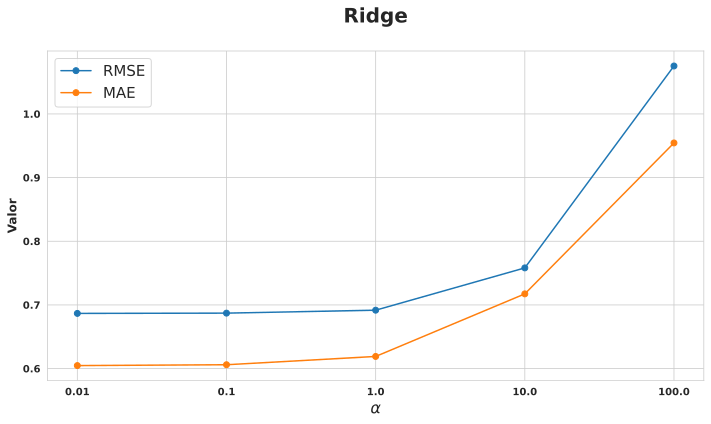

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.log(alpha_vec),rmse_list_Ridge,'o-') # Grafica del RMSE.
plt.plot(np.log(alpha_vec),mae_list_Ridge,'o-') # Grafica del MAE.
#plt.plot(np.log(alpha_vec),mse_list_Ridge,'o-') # Grafica del MSE.

# Valores de Alpha para el eje x.
nuevos_valores_x = [0.01, 0.1, 1.0, 10.0, 100.0]

# Se cambian los valores del eje x.
plt.xticks(np.log(alpha_vec), nuevos_valores_x)

plt.title('Ridge\n', fontsize = 20, fontweight = 'bold') # Se agrega título principal con letra negrita tamaño 12.
plt.xlabel(r'$\alpha$', fontsize = 16, fontweight = 'bold') # Se agrega etiqueta al eje x.
plt.ylabel('Valor', fontsize = 12, fontweight = 'bold' ) # Se agrega etiqueta al eje y.
plt.legend(['RMSE', 'MAE', 'MSE'], fontsize='15') # Se agrega la leyenda, y se modifica su tamaño.
plt.xticks(weight = 'bold')
plt.yticks(weight = 'bold')
plt.tight_layout()
plt.show()

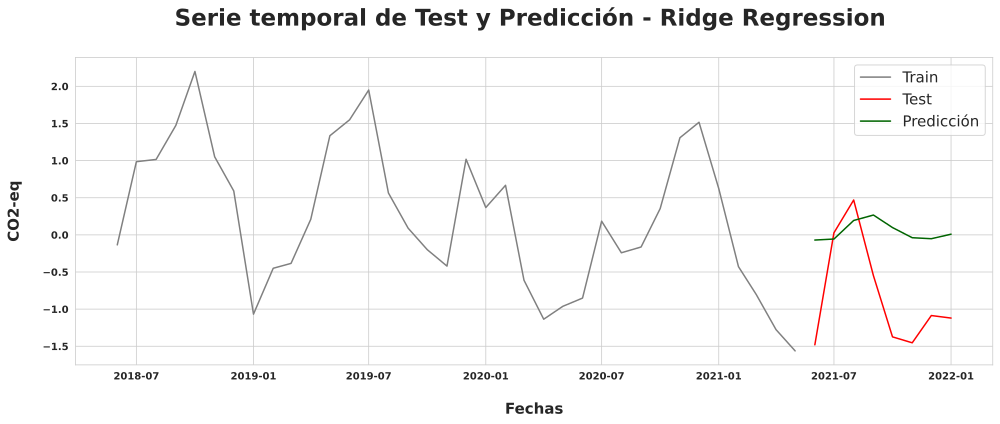

In [ ]:
# Se grafica la serie temporal de Test (Prueba) y la Predicción
plt.figure(figsize=(14,6))
plt.plot(y_train, color='grey')
plt.plot(y_test,  color='red')
plt.plot(y_test.index,y_pred_ridge,  color='darkgreen')
plt.legend(loc='upper right', labels=['Train','Test', 'Predicción'], fontsize='15')
plt.xlabel("\nFechas", fontsize = 15, fontweight='bold')
plt.ylabel("CO2-eq\n", fontsize = 15, fontweight='bold')
plt.title('Serie temporal de Test y Predicción - Ridge Regression \n', fontsize = 23, fontweight='bold') # Se agrega el título con tamaño de letra 15 y negrita 'bold'.
plt.xticks(weight = 'bold')
plt.yticks(weight = 'bold')
plt.tight_layout()
#save_fig("Serie_temporal_de_Test_y_Predicción_corregida", tight_layout=True, fig_extension="svg", resolution=300)
plt.show()

# **Regresión LASSO**

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# Se subdividen los datos en Train y Test
porcentaje = 0.2
n_train_LASSO = int(len(df_ts_lag) - len(df_ts_lag)*porcentaje)
X_train_LASSO, X_test_LASSO = df_ts_lag.iloc[0:n_train_LASSO, 0:-1], df_ts_lag.iloc[n_train_LASSO:-1, 0:-1]
y_train_LASSO, y_test_LASSO = df_ts_lag.iloc[0:n_train_LASSO, -1], df_ts_lag.iloc[n_train_LASSO:-1, -1]

alpha_vec = [1e-2, 1e-1, 1e0, 1e1, 1e2]

# Se declara el modelo LASSO
lasso_model = Lasso(alpha=1e-2)

# Training (Entrenamiento)
lasso_model.fit(X_train_LASSO, y_train_LASSO)

# Testing (Prueba - Predicciones)
y_pred_lasso = lasso_model.predict(X_test_LASSO)

# Evaluación de desempeño sobre Test
error_skl_lasso = sqrt(mean_squared_error(y_test_LASSO, y_pred_lasso))
print('RMSE: %.15f' % (error_skl_lasso))

RMSE: 0.689124552777299


In [ ]:
# Importaciones necesarias para LASSO
from sklearn.linear_model import Lasso

# PRUEBA CICLO FOR LASSO Regression
# Vector de alphas.
alpha_vec_LASSO = [1e-2, 1e-1, 1e0, 1e1, 1e2]

# Listas para almacenar los valores de RMSE, MAE, R2 y las predicciones.
rmse_list_LASSO = []
mae_list_LASSO = []
mse_list_LASSO = []
y_pred_list_lasso = []

# Se hace el ciclo for para probar diferentes valores de alpha.
for alpha in alpha_vec_LASSO:
    # Crear y entrenar el modelo LASSO.
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X_train_LASSO, y_train_LASSO)

    # Realizar predicciones en el conjunto de prueba.
    y_pred_lasso = lasso_model.predict(X_test_LASSO)
    y_pred_list_lasso.append(y_pred_lasso)

    # Se calcula el RMSE y se almacena en la lista que se creó arriba "rmse_list_LASSO".
    rmse_list_LASSO.append(sqrt(mean_squared_error(y_test_LASSO, y_pred_lasso)))
    mae_list_LASSO.append(mean_absolute_error(y_test_LASSO, y_pred_lasso))
    mse_list_LASSO.append(mean_squared_error(y_test_LASSO, y_pred_lasso))

    # Se imprime el resultado para cada valor de alpha "1e-2, 1e-1, 1e0, 1e1, 1e2".
    print(f'Alpha: {alpha}, RMSE: {rmse_list_LASSO[-1]} , MAE: {mae_list_LASSO[-1]}, MSE: {mse_list_LASSO[-1]}')

Alpha: 0.01, RMSE: 0.6891245527772994 , MAE: 0.6121363354626463, MSE: 0.474892649240513
Alpha: 0.1, RMSE: 0.7271582089571701 , MAE: 0.6805192754134691, MSE: 0.5287590608537994
Alpha: 1.0, RMSE: 1.256379076392536 , MAE: 1.1121371351284117, MSE: 1.5784883835969619
Alpha: 10.0, RMSE: 1.256379076392536 , MAE: 1.1121371351284117, MSE: 1.5784883835969619
Alpha: 100.0, RMSE: 1.256379076392536 , MAE: 1.1121371351284117, MSE: 1.5784883835969619


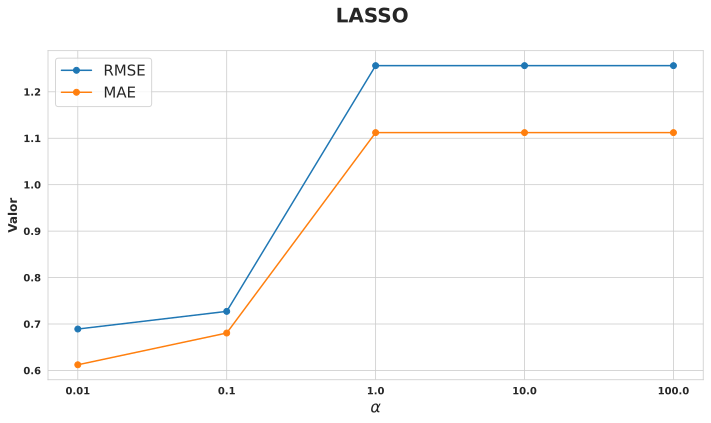

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.log(alpha_vec),rmse_list_LASSO,'o-') # Grafica del RMSE
plt.plot(np.log(alpha_vec),mae_list_LASSO,'o-') # Grafica del MAE
#plt.plot(np.log(alpha_vec),mse_list_LASSO,'o-') # Grafica del MSE

# Valores de Alpha para el eje x
nuevos_valores_x = [0.01, 0.1, 1.0, 10.0, 100.0]

# Se cambian los valores del eje x
plt.xticks(np.log(alpha_vec), nuevos_valores_x)

plt.title('LASSO \n', fontsize = 20, fontweight = 'bold') # Se agrega título principal con letra negrita tamaño 12.
plt.xlabel(r'$\alpha$', fontsize = 16, fontweight = 'bold') # Se agrega etiqueta al eje x.
plt.ylabel('Valor', fontsize = 12, fontweight = 'bold') # Se agrega etiqueta al eje y.
plt.legend(['RMSE', 'MAE', 'MSE'], fontsize='15') # Se agrega la leyenda, y se modifica su tamaño.
plt.xticks(weight = 'bold')
plt.yticks(weight = 'bold')
plt.tight_layout()
plt.show()

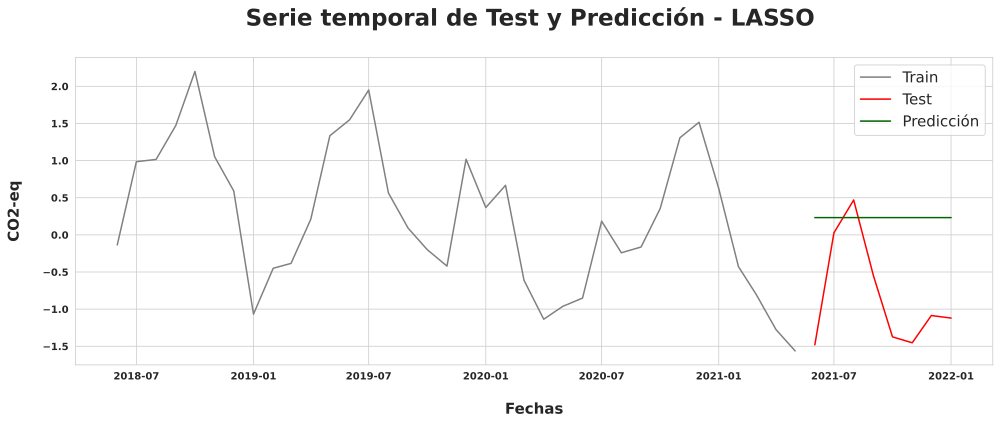

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(y_train_LASSO, color='grey')
plt.plot(y_test_LASSO, color='red')
plt.plot(y_test_LASSO.index, y_pred_lasso, color='darkgreen')
plt.legend(loc='upper right', labels=['Train', 'Test', 'Predicción'], fontsize='15')
plt.xlabel("\nFechas", fontsize=15, fontweight='bold')
plt.ylabel("CO2-eq\n", fontsize=15, fontweight='bold')
plt.title('Serie temporal de Test y Predicción - LASSO \n', fontsize=23, fontweight='bold')
plt.xticks(weight='bold')
plt.yticks(weight='bold')
plt.tight_layout()
plt.show()

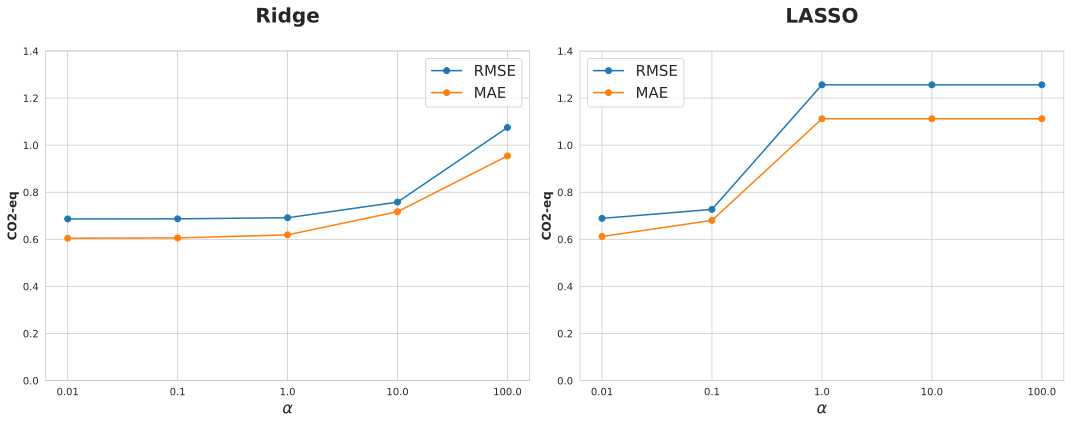

In [ ]:
# Se crean subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Primera gráfica (Ridge)
axs[0].plot(np.log(alpha_vec), rmse_list_Ridge, 'o-')
axs[0].plot(np.log(alpha_vec), mae_list_Ridge, 'o-')
#axs[0].plot(np.log(alpha_vec), mse_list_Ridge, 'o-')

nuevos_valores_x = [0.01, 0.1, 1.0, 10.0, 100.0]
axs[0].set_xticks(np.log(alpha_vec))
axs[0].set_xticklabels(nuevos_valores_x)

axs[0].set_title('Ridge\n', fontsize=20, fontweight='bold')
axs[0].set_xlabel(r'$\alpha$', fontsize=16, fontweight='bold')
axs[0].set_ylabel('CO2-eq', fontsize=12, fontweight='bold')
axs[0].legend(['RMSE', 'MAE', 'MSE'], fontsize='15')
axs[0].set_ylim(0, 1.4)  # Ajustar el rango del eje y

# Segunda gráfica (LASSO)
axs[1].plot(np.log(alpha_vec), rmse_list_LASSO, 'o-')
axs[1].plot(np.log(alpha_vec), mae_list_LASSO, 'o-')
#axs[1].plot(np.log(alpha_vec), mse_list_LASSO, 'o-')

axs[1].set_xticks(np.log(alpha_vec))
axs[1].set_xticklabels(nuevos_valores_x)

axs[1].set_title('LASSO\n', fontsize=20, fontweight='bold')
axs[1].set_xlabel(r'$\alpha$', fontsize=16, fontweight='bold')
axs[1].set_ylabel('CO2-eq', fontsize=12, fontweight='bold')
axs[1].legend(['RMSE', 'MAE', 'MSE'], fontsize='15')
axs[1].set_ylim(0, 1.4)  # Ajustar el rango del eje y

# Se ajusta el diseño
plt.tight_layout()

#save_fig("Metricas_Ridge_LASSO", tight_layout=True, fig_extension="svg", resolution=300)
# Se muestra la gráfica
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


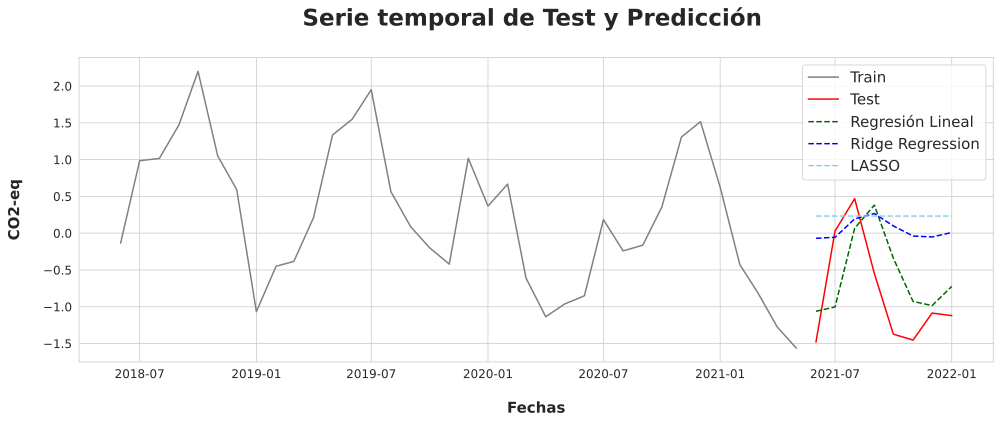

In [ ]:
# Se crea una figura y ejes comunes para las tres gráficas
fig, ax = plt.subplots(figsize=(14, 6))

# Primera gráfica - Regresión lineal
ax.plot(y_train, color='grey')
ax.plot(y_test, color='red')
ax.plot(y_test.index, y_pred, color='darkgreen', linestyle='dashed', label='Regresión Lineal')  # Se cambia el estilo y el color de la línea
ax.legend()

# Segunda gráfica - Ridge Regression
ax.plot(y_test.index, y_pred_ridge, color='blue', linestyle='dashed', label='Ridge Regression')

# Tercera gráfica - Regresión LASSO
ax.plot(y_test_LASSO.index, y_pred_lasso, color='skyblue', linestyle='dashed', label='LASSO')

ax.set_xlabel("\nFechas", fontsize=15, fontweight='bold')
ax.set_ylabel("CO2-eq\n", fontsize=15, fontweight='bold')
ax.set_title('Serie temporal de Test y Predicción \n', fontsize=23, fontweight='bold')
ax.tick_params(axis='both', which='both', labelsize=12, width='bold')
ax.legend(fontsize='15')
plt.legend(loc='upper right', labels=['Train', 'Test', 'Regresión Lineal', 'Ridge Regression', 'LASSO'], fontsize='15')
plt.tight_layout()
save_fig("Serie_test_predicciones_final", tight_layout=True, fig_extension="svg", resolution=300)
plt.show()

## <center><b>Visualización de Información</b></center>

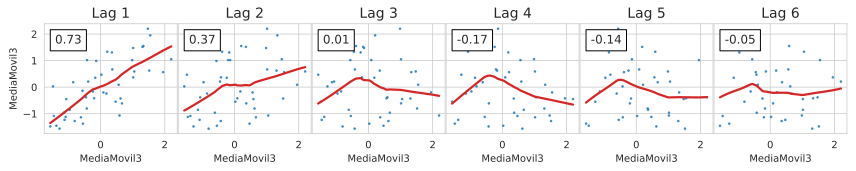

In [ ]:
_ = plot_lags(data_gei_final_completa['MediaMovil3'], lags=6, nrows=1)
#save_fig("Gráficas_del_Lag_corregida", tight_layout=True, fig_extension="svg", resolution=300)

### <center><b>Gráfica RMSE vs Media Móvil</b></center>

In [ ]:
# Se conecta el Drive donde están almacenados los datos para poder ser
# cargados correctamente
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


Ruta de Manu: /content/drive/MyDrive/Proyecto Integrador AMD/CSV de RMSE vs Media Móvil/RMSEvsMM.csv

Ruta de Santi: /content/drive/MyDrive/RMSE vs media /RMSEvsMM.csv

In [ ]:
# Se importan los datos desde Drive. Para ello agrega la ruta y
# se carga usando la función de pandas pd.read_csv

df_RMSE = pd.read_csv('/content/drive/MyDrive/Proyecto Integrador AMD/CSV de RMSE vs Media Móvil/RMSEvsMM.csv')

df_RMSE # Se imprime el DataFrame.

,RMSE,Ventana de media movil
0,0.980632,2
1,0.686617,3
2,0.528175,4
3,0.512600,5


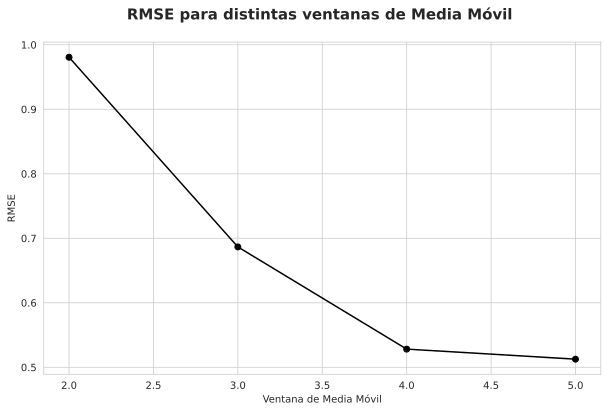

In [ ]:
# Se crea el gráfico de líneas del RMSE vs la Ventana de media Móvil
plt.figure(figsize=(10, 6)) # Se elige el tamaño del gráfico
plt.plot(df_RMSE['Ventana de media movil'], df_RMSE['RMSE'], marker='o', linestyle='-', color='black') # Se eligen las columnas a graficar, el estilo, marcadores y color.
plt.title('RMSE para distintas ventanas de Media Móvil \n', fontsize = 15, fontweight='bold') # Se elige el título principal de la gráfica, se agrega el título con tamaño de letra 15 y negrita 'bold'.
plt.xlabel('Ventana de Media Móvil') # Se elige la etiqueta del eje x.
plt.ylabel('RMSE') # Se elige la etiqueta del eje y.
plt.grid(True) # Se añade la grilla.
#save_fig("RMSE para distintas ventanas de Media Móvil (versión 1)", tight_layout=True, fig_extension="svg", resolution=300)
plt.show() # Se muestra el gráfico.

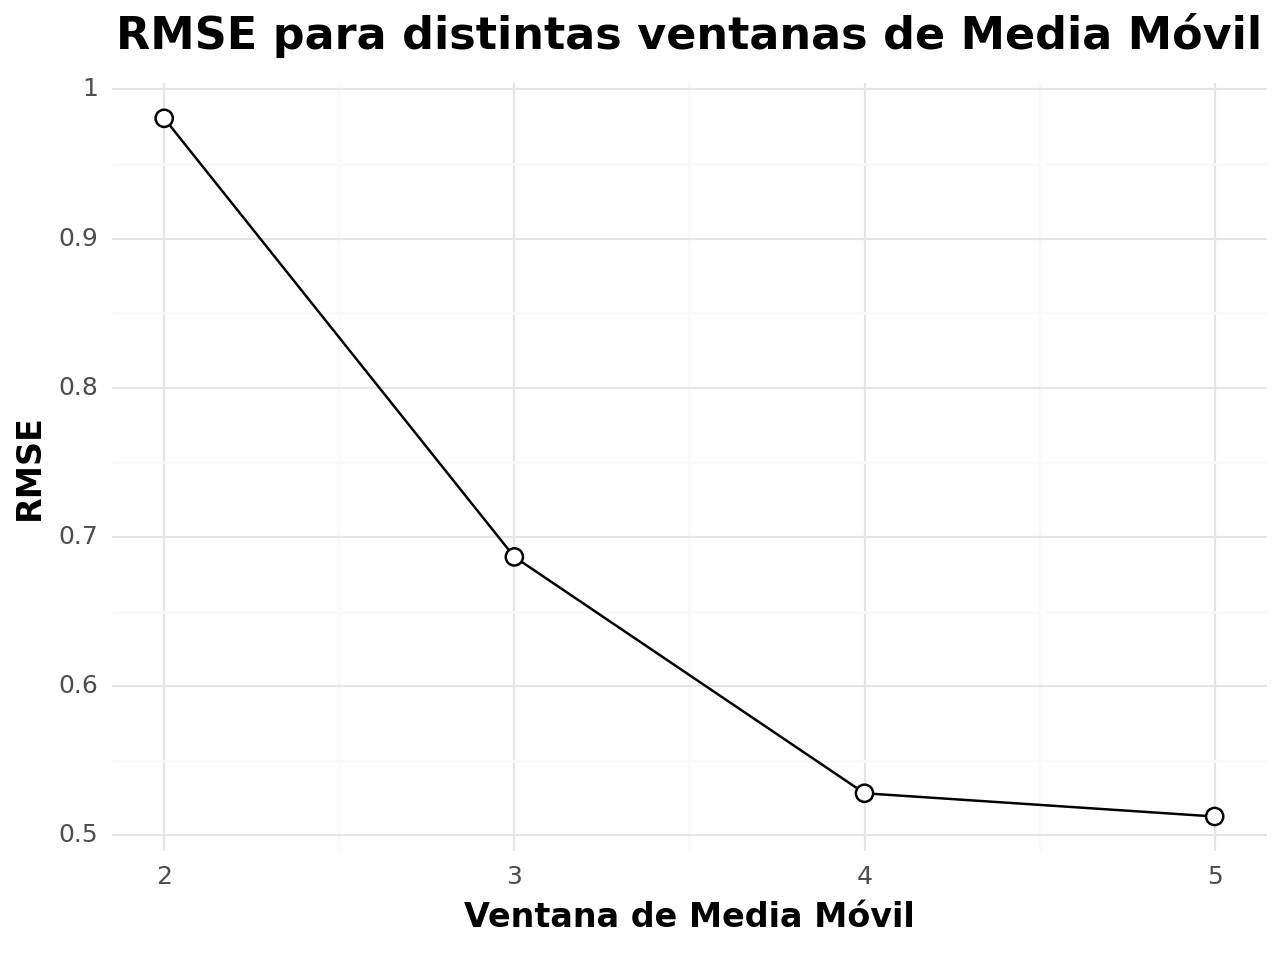

<Figure Size: (640 x 480)>

In [ ]:
# Gráfica de RMSE vs media móvil con ggplot
ggplot(df_RMSE, aes(x='Ventana de media movil', y='RMSE')) + \
    geom_line(color='black') + \
    geom_point(color='black', fill='white', size=3) + \
    labs(x='Ventana de Media Móvil', y='RMSE') + \
    theme_minimal() + \
    theme(
        axis_text=element_text(size=9),  # Se ajusta el tamaño y las "marcas" de las etiquetas de ejes
        axis_title=element_text(size=12, weight='bold'),  # Se camnbia el tamaño de las leyendas de ejes
        plot_title=element_text(size=16, weight='bold', hjust=0.5)
    ) + \
    ggtitle('RMSE para distintas ventanas de Media Móvil')
#p.save("RMSE para distintas ventanas de Media Móvil.png", width=10, height=6, dpi=300)

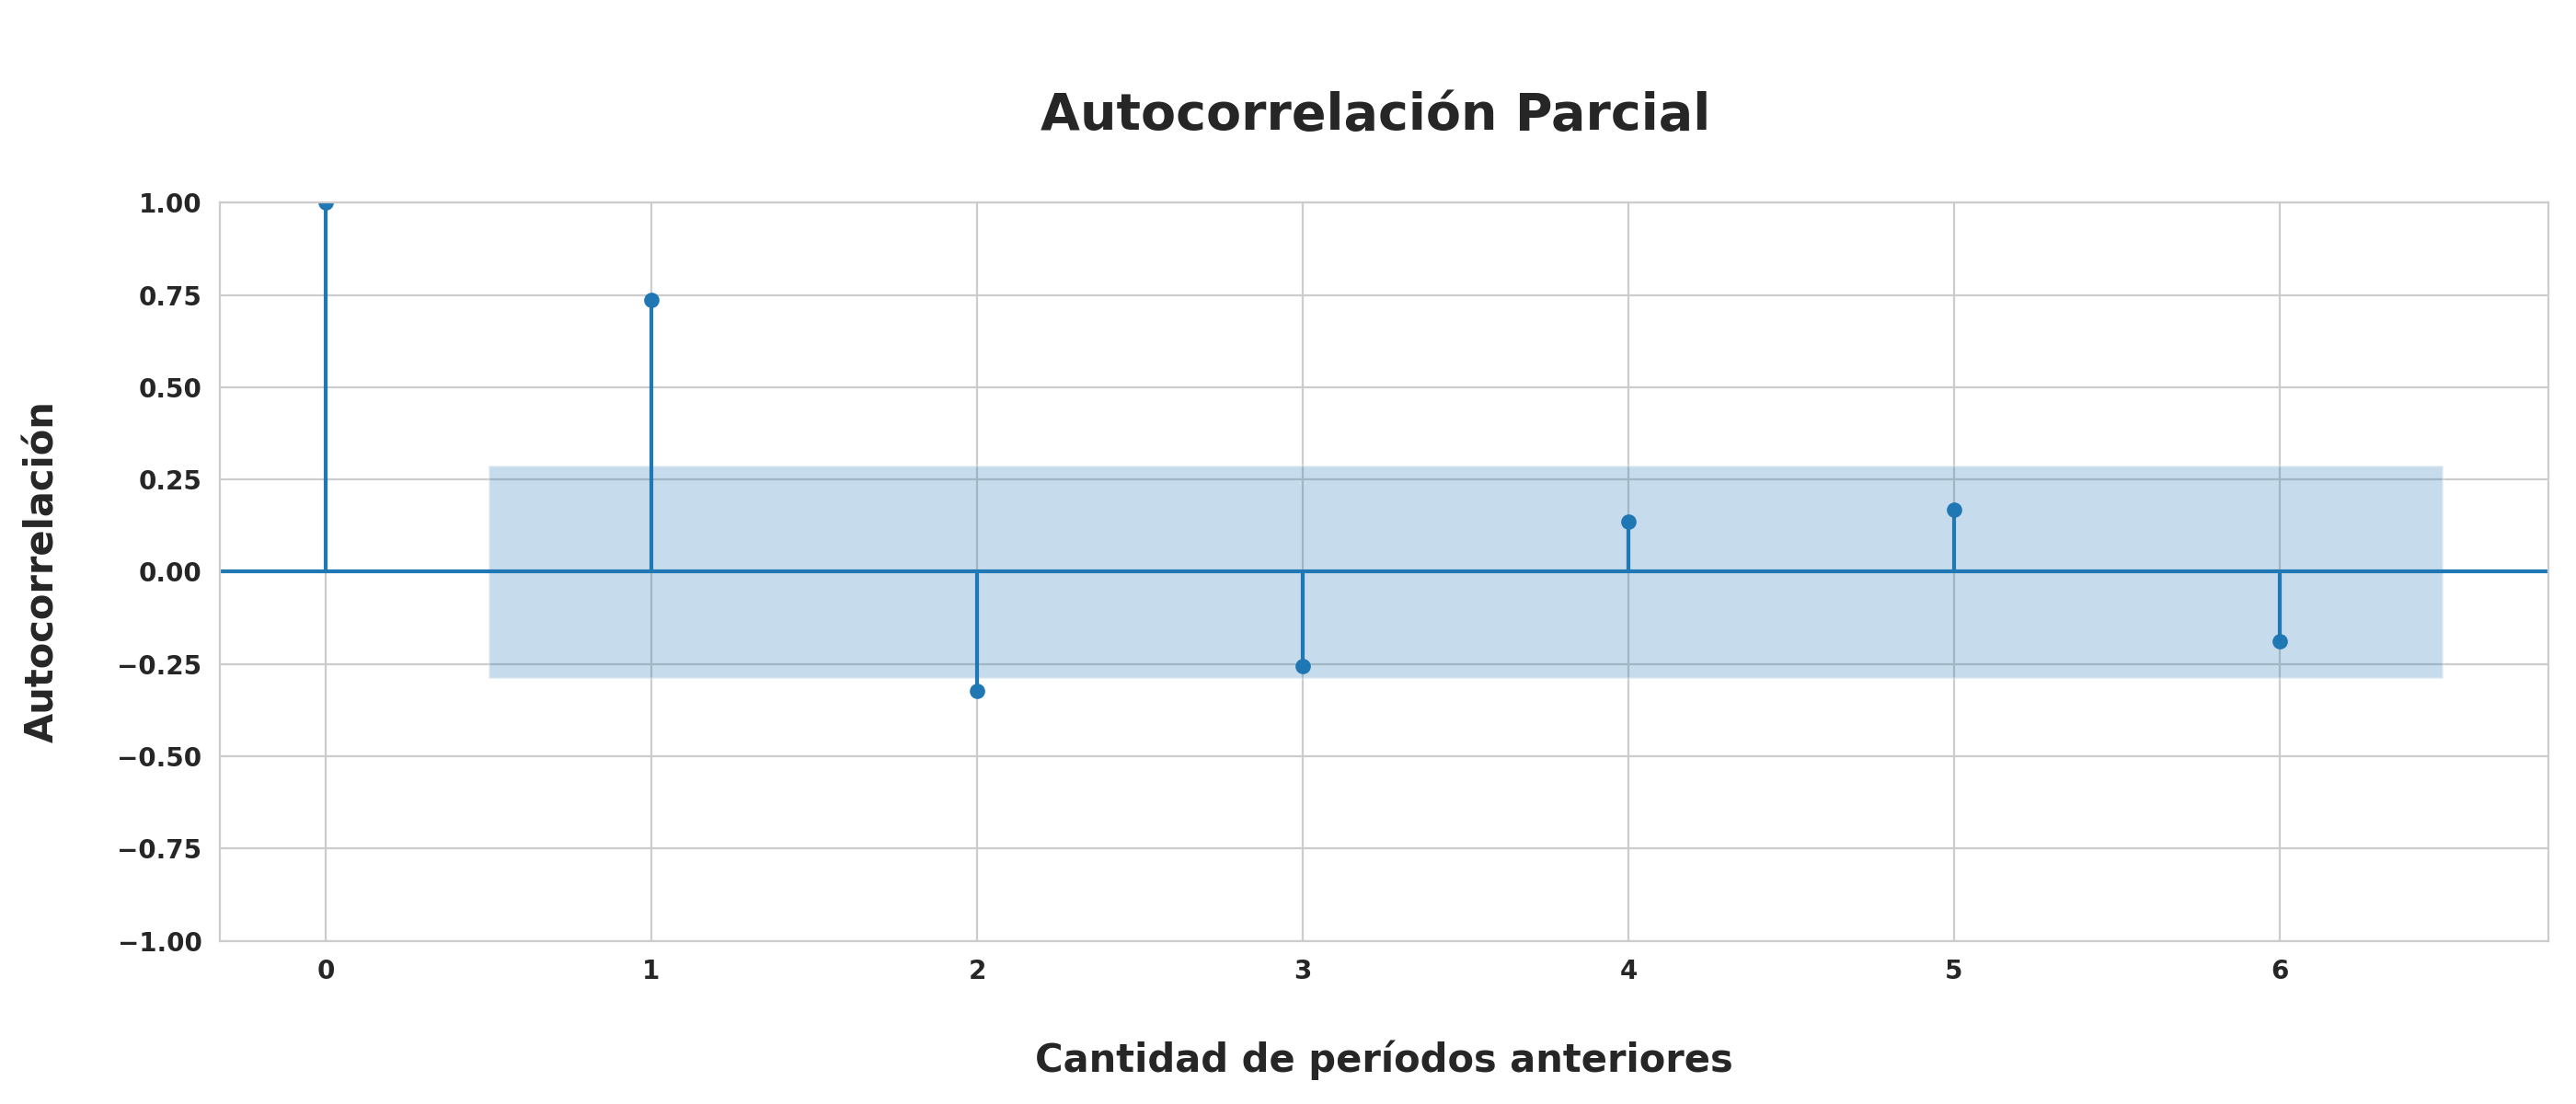

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))
sm.graphics.tsa.plot_pacf(data_gei_final_completa['MediaMovil3'].values.squeeze(), lags=6, method="ols", ax=ax)
plt.title('\nAutocorrelación Parcial \n', fontsize = 20, fontweight='bold')
plt.xlabel('\nCantidad de períodos anteriores', fontsize = 15, fontweight='bold') # Se elige la etiqueta del eje x.
plt.ylabel('Autocorrelación\n', fontsize = 15, fontweight='bold') # Se elige la etiqueta del eje y.
plt.xticks(weight = 'bold')
plt.yticks(weight = 'bold')
plt.tight_layout()
#save_fig("Autocorrelación_Parcial_corregida", tight_layout=True, fig_extension="svg", resolution=300)
plt.show()

## **Referencias**
1. Calculadora de equivalencias de gases de efecto invernadero - Cálculos y referencias | US EPA. (2023, March 2). US EPA. https://espanol.epa.gov/la-energia-y-el-medioambiente/calculadora-de-equivalencias-de-gases-de-efecto-invernadero-calculos